## Table of Content:

1. Importing the libraries and dataset
2. Data Preprocessing and Feature Engineering
3. Building the RNN
4. Making the predictions and visualising the results



## 1. Importing the libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import json
import pickle
import joblib

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

# import pad sequence
from keras_preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.text import Tokenizer

from keras.layers import Embedding



from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

2022-10-18 22:11:36.874433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 22:11:37.248398: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-18 22:11:37.321345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 22:11:37.321392: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
data=pd.read_csv("Resources/prepared_data1.csv")
data.fillna('',inplace=True)
data.head()


,Body,Label
0,save life insurance spend life quote saving en...,1
1,fight risk cancer http www adclick w p cfm pk ...,1
2,fight risk cancer http www adclick w p cfm pk ...,1
3,adult club offer free membership instant acces...,1
4,thought might like slim guaranteed lose lb day...,1


## 2. Data Preprocessing and Feature Engineering

In [4]:
texts=list(data['Body'])
labels=list(data['Label'].astype(bool))


print(len(texts),len(labels))

5293 5293


In [5]:
print("No. of 0 labels:",labels.count(0))
print("No. of 1 labels:",labels.count(1))

No. of 0 labels: 3915
No. of 1 labels: 1378


In [6]:
# Maximal length of the text
maxlen=100

# Maximal number of words to be used
max_words=10000

# instantiate tokenizer
tokenizer = Tokenizer()

# fit tokenizer on text
tokenizer.fit_on_texts(texts)

# create sequences
sequences = tokenizer.texts_to_sequences(texts)

# create word index
word_index = tokenizer.word_index

# create reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


print('Found %s unique tokens.' % len(word_index))


Found 61499 unique tokens.


In [7]:

# pad sequences
padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')


# split data into training and testing
split = int(0.8 * len(texts))


# shuffle data
indices = np.arange(padded.shape[0])
np.random.shuffle(indices)
padded = padded[indices]

labels = np.asarray(labels)
labels = labels[indices]

# split data into training and testing

train_sequences = padded[:split]
test_sequences = padded[split:]

train_labels = np.asarray(labels[:split])
test_labels = np.asarray(labels[split:])



print('Shape of training data tensor:', train_sequences.shape)
print('Shape of training label tensor:', train_labels.shape)
print('Shape of testing data tensor:', test_sequences.shape)
print('Shape of testing label tensor:', test_labels.shape)



Shape of training data tensor: (4234, 100)
Shape of training label tensor: (4234,)
Shape of testing data tensor: (1059, 100)
Shape of testing label tensor: (1059,)


## 3. Building the RNN

In [8]:

# parameters

vocab_size = len(word_index) + 1
embedding_dim = 32

# create model

# instantiate model
model = Sequential()


# add embedding layer
model.add(Embedding(vocab_size, embedding_dim))

# add LSTM layer
model.add(LSTM(32))

# add dense layer
model.add(Dense(1, activation='sigmoid'))

# model summary
model.summary()


2022-10-18 22:11:50.436573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:11:50.437081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 22:11:50.437210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-18 22:11:50.437312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-18 22:11:50.437409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          1968000   
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,976,353
Trainable params: 1,976,353
Non-trainable params: 0
_________________________________________________________________


In [9]:

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [10]:
# fit model

history = model.fit(train_sequences, train_labels,
        epochs=10, 
        validation_data=(test_sequences, test_labels), 
        verbose=2,
        batch_size=32
        
        )

Epoch 1/10
133/133 - 9s - loss: 0.4350 - accuracy: 0.8224 - val_loss: 0.2635 - val_accuracy: 0.9263 - 9s/epoch - 65ms/step
Epoch 2/10
133/133 - 6s - loss: 0.2391 - accuracy: 0.9346 - val_loss: 0.2543 - val_accuracy: 0.9282 - 6s/epoch - 45ms/step
Epoch 3/10
133/133 - 6s - loss: 0.2112 - accuracy: 0.9426 - val_loss: 0.2369 - val_accuracy: 0.9330 - 6s/epoch - 47ms/step
Epoch 4/10
133/133 - 6s - loss: 0.1797 - accuracy: 0.9528 - val_loss: 0.1931 - val_accuracy: 0.9500 - 6s/epoch - 46ms/step
Epoch 5/10
133/133 - 6s - loss: 0.3134 - accuracy: 0.9025 - val_loss: 0.1910 - val_accuracy: 0.9679 - 6s/epoch - 47ms/step
Epoch 6/10
133/133 - 6s - loss: 0.0902 - accuracy: 0.9839 - val_loss: 0.1186 - val_accuracy: 0.9679 - 6s/epoch - 44ms/step
Epoch 7/10
133/133 - 6s - loss: 0.0486 - accuracy: 0.9910 - val_loss: 0.1181 - val_accuracy: 0.9688 - 6s/epoch - 45ms/step
Epoch 8/10
133/133 - 7s - loss: 0.0321 - accuracy: 0.9946 - val_loss: 0.1146 - val_accuracy: 0.9736 - 7s/epoch - 51ms/step
Epoch 9/10
133/1

## 4. Making the predictions and visualising the results

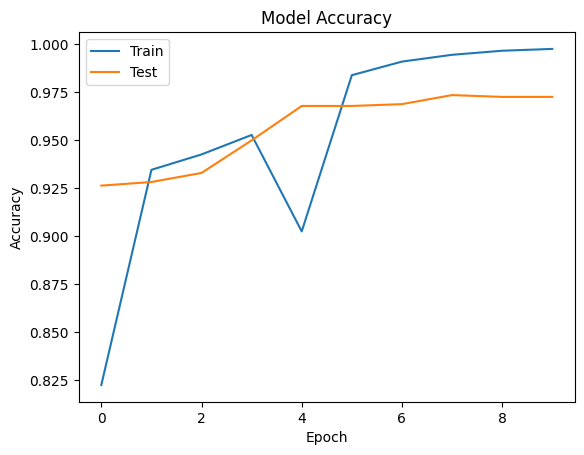

In [11]:


# plot training and validation accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()





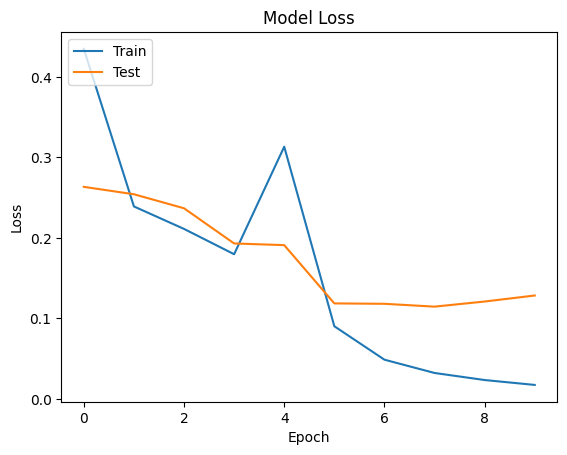

In [12]:
# plot training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [13]:

# evaluate model
loss, accuracy = model.evaluate(test_sequences, test_labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

# make predictions
predictions = model.predict(test_sequences)

# print predictions
print(predictions[:10])

# print actual values
print(test_labels[:10])



Accuracy: 97.261566
34/34 [==============================] - 1s 14ms/step
[[0.00297222]
 [0.99262154]
 [0.00290159]
 [0.00281335]
 [0.9927846 ]
 [0.00296771]
 [0.98769873]
 [0.00296757]
 [0.00127335]
 [0.0021235 ]]
[False  True False False  True False  True False False False]


In [14]:

# print confusion matrix
cm = confusion_matrix(test_labels, predictions.round())
print(cm)


[[767  14]
 [ 15 263]]


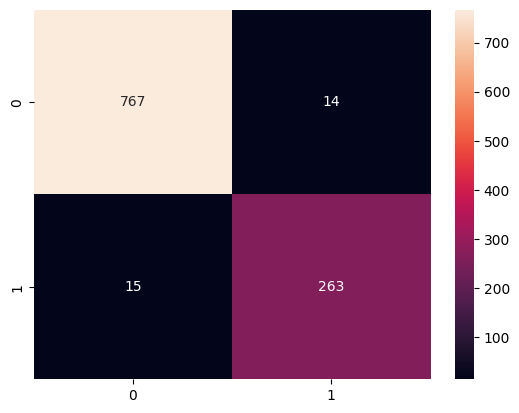

In [15]:
# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


In [28]:
# print classification report
print(classification_report(test_labels, predictions.round()))

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       786
        True       0.95      0.96      0.95       273

    accuracy                           0.98      1059
   macro avg       0.97      0.97      0.97      1059
weighted avg       0.98      0.98      0.98      1059



In [ ]:
# Saving the model

model.save("Resources/RNN_model.h5")

# Saving the tokenizer

with open('Resources/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Saving the word index

with open('Resources/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

# Saving the reverse word index

with open('Resources/reverse_word_index.json', 'w') as fp:
    json.dump(reverse_word_index, fp)


# saving  all the parameters in json

params=dict()

params['maxlen']=maxlen
params['vocab size']=vocab_size

with open('Resources/parameters.json','w') as fp:
    json.dump(params,fp)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

# import pad sequence
from keras_preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.text import Tokenizer

from keras.layers import Embedding



# parameters

vocab_size = len(word_index) + 1
embedding_dim = 32

# create model

# instantiate model
model = Sequential()


# add embedding layer
model.add(Embedding(vocab_size, embedding_dim))

# add LSTM layer
model.add(LSTM(32))

# add dense layer
model.add(Dense(1, activation='sigmoid'))

# model summary
model.summary()
